In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import os, sys
from scipy.stats import spearmanr
import sqlite3
import torch
from tqdm import tqdm

sys.path.insert(0, '../src')
sys.path.insert(1, '..')

from main import get_model
from models.config import Config, IMAGE_TOKEN_IDS
import db_utils, visualizations, utils, similarity_utils

/n/fs/ac-project/anaconda3/envs/vlm-lens-base/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sys.argv = ['notebooks/get_representations.ipynb',
            '--config', '../configs/models/qwen/Qwen2-VL-2B-Instruct-VisualBlocks.yaml']

config = Config()

In [3]:
model = get_model(config.architecture, config)

Loading checkpoint shards: 100%|██████████| 2/2 [00:08<00:00,  4.27s/it]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [5]:
print(model.model)


Qwen2VLForConditionalGeneration(
  (visual): Qwen2VisionTransformerPretrainedModel(
    (patch_embed): PatchEmbed(
      (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
    )
    (rotary_pos_emb): VisionRotaryEmbedding()
    (blocks): ModuleList(
      (0-31): 32 x Qwen2VLVisionBlock(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): VisionSdpaAttention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (mlp): VisionMlp(
          (fc1): Linear(in_features=1280, out_features=5120, bias=True)
          (act): QuickGELUActivation()
          (fc2): Linear(in_features=5120, out_features=1280, bias=True)
        )
      )
    )
    (merger): PatchMerger(
      (ln_q): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
      (mlp): Seq

In [4]:
for name, module in model.model.named_modules():
    if model.config.matches_module(name):
        print(name)

visual.blocks.0
visual.blocks.1
visual.blocks.2
visual.blocks.3
visual.blocks.4
visual.blocks.5
visual.blocks.6
visual.blocks.7
visual.blocks.8
visual.blocks.9
visual.blocks.10
visual.blocks.11
visual.blocks.12
visual.blocks.13
visual.blocks.14
visual.blocks.15
visual.blocks.16
visual.blocks.17
visual.blocks.18
visual.blocks.19
visual.blocks.20
visual.blocks.21
visual.blocks.22
visual.blocks.23
visual.blocks.24
visual.blocks.25
visual.blocks.26
visual.blocks.27
visual.blocks.28
visual.blocks.29
visual.blocks.30
visual.blocks.31
visual.merger
model.layers.0
model.layers.1
model.layers.2
model.layers.3
model.layers.4
model.layers.5
model.layers.6
model.layers.7
model.layers.8
model.layers.9
model.layers.10
model.layers.11
model.layers.12
model.layers.13
model.layers.14
model.layers.15
model.layers.16
model.layers.17
model.layers.18
model.layers.19
model.layers.20
model.layers.21
model.layers.22
model.layers.23
model.layers.24
model.layers.25
model.layers.26
model.layers.27
model.norm


In [5]:
model.run(save_tokens=True)

Running forward hooks on data: 100%|██████████| 50/50 [01:07<00:00,  1.35s/it]


In [4]:
db_path = model.config.output_db
utils.informal_log(db_path)
connection = sqlite3.connect(db_path)
connection.row_factory = sqlite3.Row
cursor = connection.cursor()

[1020_090826] ../output/Qwen2-VL-2B-Instruct-VisualBlocks.db


In [7]:
for r in cursor.execute("""
  SELECT DISTINCT layer
  FROM tensors
"""):
    print(dict(r))

{'layer': 'input_ids'}
{'layer': 'visual.blocks.0'}
{'layer': 'visual.blocks.1'}
{'layer': 'visual.blocks.2'}
{'layer': 'visual.blocks.3'}
{'layer': 'visual.blocks.4'}
{'layer': 'visual.blocks.5'}
{'layer': 'visual.blocks.6'}
{'layer': 'visual.blocks.7'}
{'layer': 'visual.blocks.8'}
{'layer': 'visual.blocks.9'}
{'layer': 'visual.blocks.10'}
{'layer': 'visual.blocks.11'}
{'layer': 'visual.blocks.12'}
{'layer': 'visual.blocks.13'}
{'layer': 'visual.blocks.14'}
{'layer': 'visual.blocks.15'}
{'layer': 'visual.blocks.16'}
{'layer': 'visual.blocks.17'}
{'layer': 'visual.blocks.18'}
{'layer': 'visual.blocks.19'}
{'layer': 'visual.blocks.20'}
{'layer': 'visual.blocks.21'}
{'layer': 'visual.blocks.22'}
{'layer': 'visual.blocks.23'}
{'layer': 'visual.blocks.24'}
{'layer': 'visual.blocks.25'}
{'layer': 'visual.blocks.26'}
{'layer': 'visual.blocks.27'}
{'layer': 'visual.blocks.28'}
{'layer': 'visual.blocks.29'}
{'layer': 'visual.blocks.30'}
{'layer': 'visual.blocks.31'}
{'layer': 'visual.merger'}


In [26]:
for r in cursor.execute("""
  SELECT id, image_id, timestamp, name, image_path, prompt, label, layer, pooling_method, tensor_dim, tensor_shape,
         length(tensor) AS tensor_bytes
  FROM tensors
  LIMIT 20
"""):
    print(dict(r))

{'id': 1, 'image_id': None, 'timestamp': '2025-10-14 15:20:08', 'name': 'Qwen/Qwen2-VL-2B-Instruct', 'image_path': '/n/fs/ac-vlm/vlm-lens/data_local/coco/cocoval/000000414795.jpg', 'prompt': 'Describe this image in one sentence.', 'label': None, 'layer': 'input_ids', 'pooling_method': None, 'tensor_dim': 1, 'tensor_shape': 'torch.Size([1, 172])', 'tensor_bytes': 2524}
{'id': 2, 'image_id': None, 'timestamp': '2025-10-14 15:20:08', 'name': 'Qwen/Qwen2-VL-2B-Instruct', 'image_path': '/n/fs/ac-vlm/vlm-lens/data_local/coco/cocoval/000000414795.jpg', 'prompt': 'Describe this image in one sentence.', 'label': None, 'layer': 'visual.blocks.31', 'pooling_method': None, 'tensor_dim': 1280, 'tensor_shape': 'torch.Size([576, 1280])', 'tensor_bytes': 1475740}
{'id': 3, 'image_id': None, 'timestamp': '2025-10-14 15:20:08', 'name': 'Qwen/Qwen2-VL-2B-Instruct', 'image_path': '/n/fs/ac-vlm/vlm-lens/data_local/coco/cocoval/000000414795.jpg', 'prompt': 'Describe this image in one sentence.', 'label': No

### For each image, calculate similarity of embeddings between pairs of layers

In [ ]:
module_names = []
module_embeddings = []
module_similarities = []
# Get input_ids
input_ids = db_utils.get_embeddings_by_layer(
    db_path=db_path,
    layer_name="input_ids",
    device="cuda")
input_ids, input_ids_same_shapes = db_utils.unwrap_embeddings(input_ids)



ValueError: too many values to unpack (expected 2)

In [25]:
# Get embeddings for each layer
# for module_name, _ in model.model.named_modules():
for module_name in ["model.norm"]:
    if not model.config.matches_module(module_name):
        continue
    print(module_name)
    module_embedding = db_utils.get_embeddings_by_layer(
        db_path=db_path,
        layer_name=module_name
    )
    try:
        module_embedding, module_embedding_same_shapes = db_utils.unwrap_embeddings(module_embedding)
    except Exception as e:
        print(module_name, module_embedding)

    # Calculate mean embedding
    mean_embeddings = db_utils.compute_mean_embeddings(
        embeddings=module_embedding)
    module_names.append(module_name)
    module_embeddings.append(mean_embeddings)

    # Calculate similarities of pairs of images
    module_sim = db_utils.cosine_similarity_numpy(mean_embeddings, mean_embeddings)
    # Assert similarity is symmetric
    assert np.array_equal(module_sim, module_sim.T)

    # Select only Upper Triangular Matrix
    n_samples = module_sim.shape[0]
    ut_idxs = np.triu_indices(n_samples, k=1)
    sim_values = module_sim[ut_idxs]
    assert len(sim_values) == n_samples * (n_samples - 1) / 2
    # Store values in list
    module_similarities.append(sim_values)

    # Compute mean embedding of visual tokens only (if applicable)
    if module_name.startswith("model"):
        module_visual_embedding, n_visual_tokens = db_utils.extract_visual_embeddings(
            input_ids=input_ids,
            llm_embeddings=module_embedding,
            image_token_id=IMAGE_TOKEN_IDS[config.architecture],
            same_shapes=module_embedding_same_shapes
        )
        # Calculate mean embedding
        visual_mean_embeddings = db_utils.compute_mean_embeddings(
            embeddings=module_visual_embedding,
            n_embeddings=n_visual_tokens)
        # Compute similarity
        module_sim = db_utils.cosine_similarity_numpy(visual_mean_embeddings, visual_mean_embeddings)
        # Assert similarity is symmetric
        assert np.array_equal(module_sim, module_sim.T)

        # Select only Upper Triangular Matrix
        n_samples = module_sim.shape[0]
        ut_idxs = np.triu_indices(n_samples, k=1)
        sim_values = module_sim[ut_idxs]
        assert len(sim_values) == n_samples * (n_samples - 1) / 2

        # Store values in list
        module_names.append("{}-visual".format(module_name))
        module_embeddings.append(visual_mean_embeddings)
        module_similarities.append(sim_values)



model.norm


In [ ]:
print(module_names)
print(module_similarities[0].shape, module_similarities[1].shape)
print(module_embeddings[0].shape, module_embeddings[1].shape)

['model.norm', 'model.norm-visual']
(1225,) (1225,)


In [ ]:
visual_names, visual_embs, visual_sims = similarity_utils.compute_image_pair_similarities(
    database_path=db_path,
    model=model,
    layer_names=['model.norm'],
    extract_visual_tokens=True)

model.norm


In [26]:
print(np.array(visual_embs).shape)
print(np.array(module_embedding[1]).shape)
print(np.array(module_embedding[0]).shape)
print(np.array(visual_embs)[:5, :5])
print(np.array(module_embedding[1])[:5, :5])

(1, 50, 1536)
(172, 1536)
(172, 1536)
[[[ -2.61923218  -9.61315918   3.25558302 ...  -2.02469889   1.4862637
     1.01981269]
  [ -1.52073648 -11.36130778   1.67143228 ...  -1.6037284   -3.06074015
    -0.39435832]
  [ -0.69318602  -7.95814345   3.77953423 ...  -2.30280092   0.94132487
    -0.34488593]
  [ -2.57516903  -3.85864258   0.41309018 ...   0.04907735   1.77651638
    -0.12681749]
  [ -1.17917209 -11.38186306   1.92657132 ...  -1.0068086    1.02960205
    -0.23829905]]]
[[ -0.01269531   0.4296875   -0.171875     0.42382812   0.44726562]
 [ -1.1328125    1.8203125    2.6875       2.28125      3.328125  ]
 [ -2.515625     8.5          0.765625    -5.65625      5.6875    ]
 [ -4.0625     -12.625        0.9609375   -1.984375    -6.8125    ]
 [ -2.171875    -9.5          7.25         1.5078125   -2.6875    ]]


0 visual.blocks.0
1 visual.blocks.1
2 visual.blocks.2
3 visual.blocks.3
4 visual.blocks.4
5 visual.blocks.5
6 visual.blocks.6
7 visual.blocks.7
8 visual.blocks.8
9 visual.blocks.9
10 visual.blocks.10
11 visual.blocks.11
12 visual.blocks.12
13 visual.blocks.13
14 visual.blocks.14
15 visual.blocks.15
16 visual.blocks.16
17 visual.blocks.17
18 visual.blocks.18
19 visual.blocks.19
20 visual.blocks.20
21 visual.blocks.21
22 visual.blocks.22
23 visual.blocks.23
24 visual.blocks.24
25 visual.blocks.25
26 visual.blocks.26
27 visual.blocks.27
28 visual.blocks.28
29 visual.blocks.29
30 visual.blocks.30
31 visual.blocks.31
32 visual.merger
33 model.layers.0
34 model.layers.0-visual
35 model.layers.1
36 model.layers.1-visual
37 model.layers.2
38 model.layers.2-visual
39 model.layers.3
40 model.layers.3-visual
41 model.layers.4
42 model.layers.4-visual
43 model.layers.5
44 model.layers.5-visual
45 model.layers.6
46 model.layers.6-visual
47 model.layers.7
48 model.layers.7-visual
49 model.layers.8
5

<Figure size 640x480 with 0 Axes>

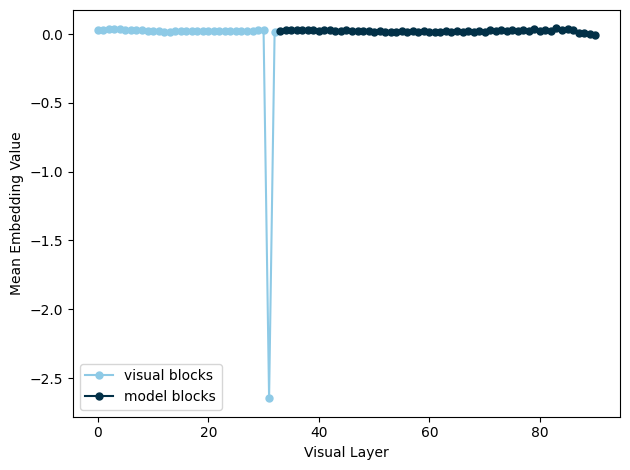

<Figure size 640x480 with 0 Axes>

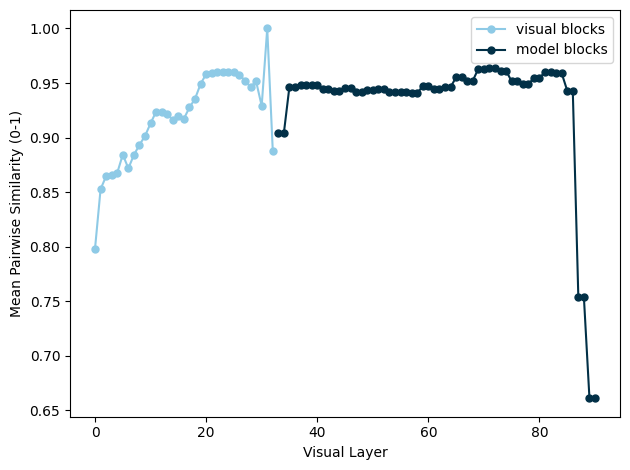

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Visual Layer', ylabel='Mean Pairwise Similarity (0-1)'>)

In [6]:
# For each layer, calculate the mean similarity and the norm
mean_embeddings = {}
mean_similarities = {}

for idx, (name, embs, sims) in enumerate(zip(module_names, module_embeddings, module_similarities)):
    print(idx, name)

    key = name.split(".")[0]
    if key in mean_embeddings:
        mean_embeddings[key].append(np.mean(embs))
    else:
        mean_embeddings[key] = [np.mean(embs)]

    if key in mean_similarities:
        mean_similarities[key].append(np.mean(sims))
    else:
        mean_similarities[key] = [np.mean(sims)]

# Plot mean embeddings
xs = []
ys = []
labels = []

n_items = 0
for k, v in mean_embeddings.items():
    xs.append([i + n_items for i in range(len(v))])
    ys.append(v)
    labels.append("{} blocks".format(k))
    n_items += len(v)
print(len(ys[0]))
visualizations.plot(
    xs=xs,
    ys=ys,
    labels=labels,
    xlabel='Visual Layer',
    ylabel='Mean Embedding Value',
    show=True
)

xs = []
ys = []
labels = []
n_items = 0
for k, v in mean_similarities.items():
    xs.append([i + n_items for i in range(len(v))])
    ys.append(v)
    labels.append("{} blocks".format(k))
    n_items += len(v)
visualizations.plot(
    xs=xs,
    ys=ys,
    labels=labels,
    xlabel='Visual Layer',
    ylabel='Mean Pairwise Similarity (0-1)',
    show=True
)
